In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import arch
from arch.unitroot import ADF
from arch import arch_model
import matplotlib.pyplot as plt
import datetime

In [2]:
def full_month(ticker):
    today = datetime.datetime.now()
    four = (today - datetime.timedelta(days = 28)).date().strftime("%Y-%m-%d")
    three = (today - datetime.timedelta(days = 21)).date().strftime("%Y-%m-%d")
    two = (today - datetime.timedelta(days = 14)).date().strftime("%Y-%m-%d")
    one = (today - datetime.timedelta(days = 7)).date().strftime("%Y-%m-%d")
    t43 = yf.download(tickers=ticker, start=four, end=three, interval="1m")
    t32 = yf.download(tickers=ticker, start=three, end=two, interval="1m")
    t21 = yf.download(tickers=ticker, start=two, end=one, interval="1m")
    t10 = yf.download(tickers=ticker, period="7d", interval="1m")
    ticker = pd.concat([t43, t32, t21, t10])
    return ticker

In [3]:
def conditional_vol(ticker):
    ticker = full_month(ticker)
    returns = 10000 * (ticker["Close"].pct_change().dropna())
    arch = arch_model(returns, dist="skewt")
    result = arch.fit()
    return ticker, returns, result.conditional_volatility

In [4]:
def get_hurst_exponent(data):
    time_series = data["Close"].values
    lags = range(2, 12)
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [6]:
def t1_to_t2_backtest(ticker1, ticker2, correlated, std_ct):
    t1, t1_returns, t1_vol = conditional_vol(ticker1)
    t2, t2_returns, t2_vol = conditional_vol(ticker2)
    tick1 = t1
    tick2 = t2
    hurst = get_hurst_exponent(t2)
    if correlated:
        t1_diff = t1_returns - t1_vol
        t1_times = t1_diff[t1_diff > 0].reset_index()
    else:
        t1_diff = t1_returns + t1_vol
        t1_times = t1_diff[t1_diff < 0].reset_index()
    t2 = t2.reset_index().reset_index()
    t2_vol = t2_vol.reset_index()
    entries = t2.loc[t2["Datetime"].isin(t1_times["Datetime"])].reset_index(drop=True)
    entry_vols = t2_vol.loc[t2_vol["Datetime"].isin(t1_times["Datetime"])].reset_index(drop=True)
    entries["Current Vol"] = entry_vols["cond_vol"]
    ctime = entries["Datetime"][0]
    sells = []
    buys = []
    for index, row in entries.iterrows():
        if row["Datetime"] < ctime:
            continue
        open_time = row["Datetime"]
        buys.append(open_time)
        cost = row["Close"]
        bound = (row["Current Vol"]/10000)*cost
        remainder = t2.loc[t2["index"] > row["index"]]
        for i, r in remainder.iterrows():
            if abs(r["Close"] - cost) >= bound*std_ct*(2*hurst):
                sale = r["Close"]
                ctime = r["Datetime"]
                sells.append(ctime)
                break
    sells = pd.Series(sells)
    buys = pd.Series(buys)
    return tick1, tick2, buys, sells

In [7]:
def generate_data(ticker1, ticker2, correlated, std_ct):
    t1, t2, buy, sell = t1_to_t2_backtest(ticker1, ticker2, correlated, std_ct)
    merged = pd.merge(t1, t2, how='inner', left_index=True, right_index=True)
    merged = merged[["Close_x", "Close_y"]]
    merged.rename(columns={"Close_x": ticker1, "Close_y": ticker2})
    merged = merged.drop_duplicates()
    merged = merged.reset_index()
    merged['Signals'] = np.select([merged["Datetime"].isin(buy), merged["Datetime"].isin(sell)],[1,-1],0)
    merged = merged.drop(columns=['Datetime'])
    merged.to_csv(ticker1 + "_" + ticker2 + "_gen" + ".csv")
    return merged
    

In [26]:
generate_data("ENPH", "SEDG", False, 1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 37618.2546167064
Iteration:      2,   Func. Count:     17,   Neg. LLF: 37420.002306498136
Iteration:      3,   Func. Count:     26,   Neg. LLF: 36987.57985262647
Iteration:      4,   Func. Count:     35,   Neg. LLF: 36714.6676422509
Iteration:      5,   Func. Count:     44,   Neg. LLF: 36648.463530638546
Iteration:      6,   Func. Count:     53,   Neg. LLF: 36530.09286171199
Iteration:      7,   Func. Count:     62,   Neg. LLF: 36405.632506956914
Iteration:      8,   Func. Count:     71,   Neg. LLF: 36324.8307552825
Iteration:      9,   Func. Count:     80,   Neg. LLF: 36252.89105745399
Iteration:     10,   Func. Count:     89,   Neg. LLF: 36194.36435911419
Iter

Iteration:     44,   Func. Count:    387,   Neg. LLF: 32340.010048800217
Iteration:     45,   Func. Count:    396,   Neg. LLF: 32333.967849131666
Iteration:     46,   Func. Count:    405,   Neg. LLF: 32327.144395857893
Iteration:     47,   Func. Count:    414,   Neg. LLF: 32323.683269589856
Iteration:     48,   Func. Count:    423,   Neg. LLF: 32319.58543705073
Iteration:     49,   Func. Count:    432,   Neg. LLF: 32317.22014711793
Iteration:     50,   Func. Count:    441,   Neg. LLF: 32316.066950162305
Iteration:     51,   Func. Count:    450,   Neg. LLF: 32315.819965681476
Iteration:     52,   Func. Count:    458,   Neg. LLF: 32315.610284825016
Iteration:     53,   Func. Count:    466,   Neg. LLF: 32314.84376531729
Iteration:     54,   Func. Count:    474,   Neg. LLF: 32313.141382007576
Iteration:     55,   Func. Count:    482,   Neg. LLF: 32312.75577905253
Iteration:     56,   Func. Count:    490,   Neg. LLF: 32312.644565680464
Iteration:     57,   Func. Count:    498,   Neg. LLF: 3

,Datetime,Close_x,Close_y,Signals
0,2022-04-06 09:30:00-04:00,208.000000,325.480011,0
1,2022-04-06 09:31:00-04:00,207.419998,326.464996,0
2,2022-04-06 09:32:00-04:00,207.259598,322.000000,0
3,2022-04-06 09:33:00-04:00,205.029999,321.160004,1
4,2022-04-06 09:34:00-04:00,205.009995,322.225006,0
...,...,...,...,...
7010,2022-05-04 15:56:00-04:00,191.990005,283.970001,0
7011,2022-05-04 15:57:00-04:00,192.080002,284.200012,0
7012,2022-05-04 15:58:00-04:00,192.035004,284.420013,-1
7013,2022-05-04 15:59:00-04:00,192.020004,284.600006,0


C:\Users\Michael\Documents\GitHub\QuantMacroSP2022\backtest.py:39: RuntimeWarning: invalid value encountered in true_divide
  self.absolute_values.append(self.absolute_values[-1] * (1 + np.dot(weights,((prices - self.yesterday_prices) / self.yesterday_prices))))
C:\Users\Michael\Documents\GitHub\QuantMacroSP2022\backtest.py:39: RuntimeWarning: divide by zero encountered in true_divide
  self.absolute_values.append(self.absolute_values[-1] * (1 + np.dot(weights,((prices - self.yesterday_prices) / self.yesterday_prices))))


Sharpe: nan
Max Drawdon: 0
Total Return: nan
Percent Return: nan


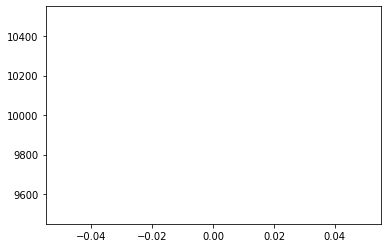

In [8]:
from backtest import backtest
import numpy as np
from scipy.optimize import minimize



'''
strat_function(preds, prices) - user specified mapping from past n days of price and analyst data to weights.
Returns: An array of asset weightings. The maximum weighting is 1, and the minimum is -1. The weights must sum to between -1 and 1. 

Refer to test datasets for the shape of input data. Both preds and prices will be 2 dimensional arrays, with number of columns equal to number of assets + 1.
Number of days equal to number of rows. The first column will be date data.

Your strategy function needs to work with this data to generate portfolio weights.


'''

def strat_function(preds, prices, last_weights): 
    # IGNORE PREDS FOR THIS    
    prices = np.array(prices)
    
    signal = prices[:, -1][-1]
    if signal == 1:
        return [0, 1, 0]
    if signal == -1:
        return [0, 0, 0]
    if signal == 0:
        return last_weights
    

'''
Running the backtest - starting portfolio value of 10000, reading in data from these two locations.
'''
backtest(strat_function, 10000, "SEDG-ENPH-Signal.csv", "SEDG-ENPH-Signal.csv")

